In [1]:
from dataloader import load_balanced_binary_dataset
import backend.src.utils.utils as utils

In [2]:
data = load_balanced_binary_dataset()
data = utils.clean_text(data, "text")

In [3]:
data

,sent_id,text,label
759,200323-15-01,første biten gikk relativt smertefritt,1
2426,202607-21-02,komfortnivået nemlig,1
4283,202298-17-01,sikkerhet,1
2912,101115-13-03,likhet nordtveit leverte bedre estland,1
648,500700-03-02,beundringsverdig våger utenfor opplagte ruten ...,1
...,...,...,...
3752,702152-09-01,regissør foster følt beverdokka funker ordentl...,0
1949,600103-04-02,samtidig minnet verden overhodet tillokkende e...,0
3744,702152-04-02,mel gibson spiller deprimerte familiefaren ans...,0
4706,400215-15-03,stedet ta turen kino grav sofaen se originalfi...,0


In [4]:
from collections import Counter
import math

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 13000


<AxesSubplot:>

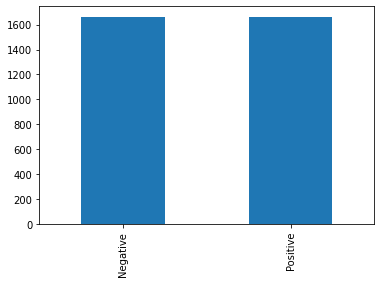

In [5]:
data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

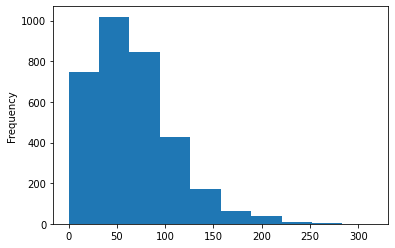

In [6]:
data["text"].str.len().plot.hist()

In [7]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_val, y_train, y_val = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42,
                                                  shuffle=True)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

print("X_train size:", len(X_train))
print("y_train size:", len(y_train))
print("X_val size:", len(X_val))
print("y_val size:", len(y_val))

X_train size: 2660
y_train size: 2660
X_val size: 666
y_val size: 666


In [8]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 557 contains 8 words and is Positive
Review content:

timer funksjonen enkel forventer enten daglig ukentlig støvsuging


In [9]:
word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [10]:
word_counter.most_common(10)

[('litt', 129),
 ('the', 91),
 ('filmen', 87),
 ('får', 76),
 ('godt', 74),
 ('to', 73),
 ('gjør', 73),
 ('nok', 72),
 ('helt', 70),
 ('første', 62)]

In [11]:
import numpy as np

maxlen = 150

X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

y_train = np.array(y_train)
y_val = np.array(y_val)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (2660, 150)
X_val shape: (666, 150)
y_train shape: (2660,)
y_val shape: (666,)


In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import regularizers

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(LSTM(units=128, dropout=0.2, kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(units=1, activation='sigmoid'))

In [13]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1664000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,795,713
Trainable params: 1,795,713
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
167/167 [==============================] - 49s 270ms/step - loss: 0.8665 - accuracy: 0.5305 - val_loss: 0.6892 - val_accuracy: 0.5405
Epoch 2/20
167/167 [==============================] - 34s 205ms/step - loss: 0.5115 - accuracy: 0.8169 - val_loss: 0.7576 - val_accuracy: 0.6321
Epoch 3/20
167/167 [==============================] - 37s 219ms/step - loss: 0.1882 - accuracy: 0.9500 - val_loss: 0.8579 - val_accuracy: 0.6351
Epoch 4/20
167/167 [==============================] - 38s 227ms/step - loss: 0.1113 - accuracy: 0.9801 - val_loss: 1.0940 - val_accuracy: 0.6276
Epoch 5/20
167/167 [==============================] - 41s 247ms/step - loss: 0.0765 - accuracy: 0.9880 - val_loss: 1.0148 - val_accuracy: 0.6411
Epoch 6/20
167/167 [==============================] - 42s 254ms/step - loss: 0.0528 - accuracy: 0.9947 - val_loss: 1.2618 - val_accuracy: 0.6156
Epoch 7/20
167/167 [==============================] - 39s 233ms/step - loss: 0.0427 - accuracy: 0.9951 - val_loss: 1.2868 - val_ac

In [15]:
from datetime import datetime

model.save(f"models/SA-LSTM-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

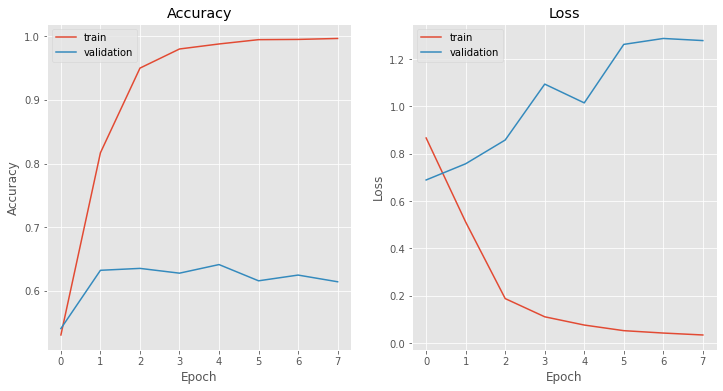

In [16]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [17]:
# Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

21/21 [==============================] - 2s 102ms/step - loss: 1.2778 - accuracy: 0.6141
Validation loss: 1.2778370380401611
Validation accuracy: 0.6141141057014465
